In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as tfms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import numpy as np

C:\Users\201910810\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\201910810\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### maxout

In [2]:
class Maxout(nn.Module):
    def __init__(self, in_features, out_features, num_pieces):
        super(Maxout, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.num_pieces = num_pieces

        self.lin = nn.Linear(in_features, out_features * num_pieces)

    def forward(self, x):
        lin = self.lin(x)
        y = lin.view(-1, self.num_pieces, self.out_features).max(dim=1)[0]
        return y### maxout

In [3]:
EPOCHS = 300
BATCH_SIZE = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# trainset = dsets.FashionMNIST(
#     root='./data/', 
#     train=True, 
#     transform=tfms.Compose([
#         tfms.ToTensor(),
#         tfms.Normalize([0.5,], [0.5,])
#     ]),
#     download=True
# )
trainset = dsets.MNIST(
    root='./data/', 
    train=True, 
    transform=tfms.Compose([
        tfms.ToTensor(),
        tfms.Normalize([0.5,], [0.5,])
    ]),
    download=True
)

In [5]:
data_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE, 
    shuffle = True
)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.embed = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        c = self.embed(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(10, 10)
        
        self.y_max = nn.Sequential(
            Maxout(10, 50, 5),
            # nn.Dropout(0.8)
        )
        self.x_max = nn.Sequential(
            Maxout(784, 240, 5),
            nn.Dropout(0.8)
        )
        
        self.model = nn.Sequential(
            Maxout(290, 240, 4),
            nn.Linear(240, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, label):
        c = self.embed(label)
        x_m = self.x_max(x)
        y_m = self.y_max(c)
        x = torch.cat([x_m, y_m], dim=1)
        return self.model(x)

In [7]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.embed = nn.Embedding(10, 10)
        
#         self.model = nn.Sequential(
#             nn.Linear(794, 1024),
#             nn.LeakyReLU(0.2, True),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2, True),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, True),
#             nn.Dropout(0.3),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x, label):
#         c = self.embed(label)
#         x = torch.cat([x, c], dim=1)
#         return self.model(x)

In [8]:
D = Discriminator().to(device)
G = Generator().to(device)

criterion = nn.BCELoss()
d_optim = optim.Adam(D.parameters(), lr=0.0002)
g_optim = optim.Adam(G.parameters(), lr=0.0002)

C:\Users\201910810\Anaconda3\lib\site-packages\torch\cuda\__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3060 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3060 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [9]:
nums = [x for x in range(10)]
test_nums = []
for i in range(10):
    test_nums += nums
plot_label = torch.tensor(test_nums, dtype=torch.long).to(device)

Epoch [  0|300]    Loss [D:0.655777 | G:3.522167]    [D(x)  0.786524| D(G(z)) 0.183045]


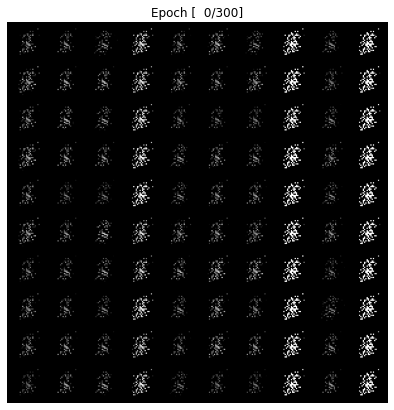

Epoch [  1|300]    Loss [D:0.695774 | G:3.164615]    [D(x)  0.848554| D(G(z)) 0.225984]
Epoch [  2|300]    Loss [D:0.718644 | G:2.127693]    [D(x)  0.784999| D(G(z)) 0.239421]
Epoch [  3|300]    Loss [D:0.839000 | G:1.776012]    [D(x)  0.723799| D(G(z)) 0.249514]
Epoch [  4|300]    Loss [D:0.774227 | G:1.861681]    [D(x)  0.736340| D(G(z)) 0.258352]
Epoch [  5|300]    Loss [D:0.767799 | G:2.012138]    [D(x)  0.762576| D(G(z)) 0.246212]
Epoch [  6|300]    Loss [D:0.872336 | G:1.753431]    [D(x)  0.747662| D(G(z)) 0.285849]
Epoch [  7|300]    Loss [D:0.858413 | G:1.673514]    [D(x)  0.745096| D(G(z)) 0.295028]
Epoch [  8|300]    Loss [D:0.937284 | G:1.504109]    [D(x)  0.694778| D(G(z)) 0.308117]
Epoch [  9|300]    Loss [D:1.042757 | G:1.567586]    [D(x)  0.666835| D(G(z)) 0.342838]
Epoch [ 10|300]    Loss [D:0.915614 | G:1.649123]    [D(x)  0.686584| D(G(z)) 0.286868]
Epoch [ 11|300]    Loss [D:0.794266 | G:1.585874]    [D(x)  0.732122| D(G(z)) 0.271517]
Epoch [ 12|300]    Loss [D:1.103

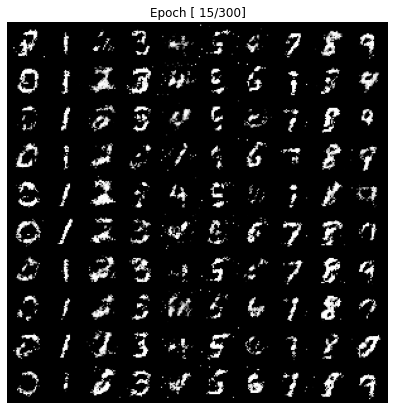

Epoch [ 16|300]    Loss [D:1.133805 | G:1.211162]    [D(x)  0.599400| D(G(z)) 0.378798]
Epoch [ 17|300]    Loss [D:1.256426 | G:1.179072]    [D(x)  0.595541| D(G(z)) 0.434114]
Epoch [ 18|300]    Loss [D:1.214679 | G:1.034089]    [D(x)  0.546270| D(G(z)) 0.364257]
Epoch [ 19|300]    Loss [D:1.125815 | G:1.173167]    [D(x)  0.597819| D(G(z)) 0.390685]
Epoch [ 20|300]    Loss [D:1.017186 | G:1.326802]    [D(x)  0.624181| D(G(z)) 0.354699]
Epoch [ 21|300]    Loss [D:1.141533 | G:1.140349]    [D(x)  0.603661| D(G(z)) 0.401060]
Epoch [ 22|300]    Loss [D:1.028084 | G:1.294552]    [D(x)  0.605165| D(G(z)) 0.332860]
Epoch [ 23|300]    Loss [D:1.146405 | G:1.113977]    [D(x)  0.585993| D(G(z)) 0.381058]
Epoch [ 24|300]    Loss [D:1.195951 | G:1.052054]    [D(x)  0.585235| D(G(z)) 0.433407]
Epoch [ 25|300]    Loss [D:1.336736 | G:0.800721]    [D(x)  0.551900| D(G(z)) 0.470828]
Epoch [ 26|300]    Loss [D:1.364555 | G:0.833543]    [D(x)  0.521893| D(G(z)) 0.438629]
Epoch [ 27|300]    Loss [D:1.286

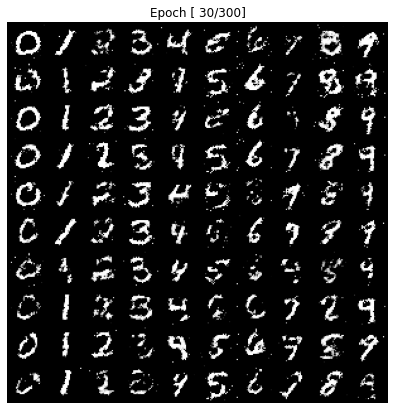

Epoch [ 31|300]    Loss [D:1.355644 | G:0.828304]    [D(x)  0.535403| D(G(z)) 0.470269]
Epoch [ 32|300]    Loss [D:1.171717 | G:0.978082]    [D(x)  0.592465| D(G(z)) 0.424247]
Epoch [ 33|300]    Loss [D:1.271589 | G:0.934970]    [D(x)  0.504016| D(G(z)) 0.403951]
Epoch [ 34|300]    Loss [D:1.235604 | G:0.973210]    [D(x)  0.567417| D(G(z)) 0.432891]
Epoch [ 35|300]    Loss [D:1.407370 | G:0.725412]    [D(x)  0.516583| D(G(z)) 0.485639]
Epoch [ 36|300]    Loss [D:1.252539 | G:0.922714]    [D(x)  0.551354| D(G(z)) 0.445836]
Epoch [ 37|300]    Loss [D:1.374501 | G:0.751106]    [D(x)  0.499482| D(G(z)) 0.461941]
Epoch [ 38|300]    Loss [D:1.426692 | G:0.757226]    [D(x)  0.535008| D(G(z)) 0.500680]
Epoch [ 39|300]    Loss [D:1.308948 | G:0.737385]    [D(x)  0.537703| D(G(z)) 0.467508]
Epoch [ 40|300]    Loss [D:1.412937 | G:0.779655]    [D(x)  0.518308| D(G(z)) 0.487850]
Epoch [ 41|300]    Loss [D:1.386491 | G:0.759147]    [D(x)  0.519888| D(G(z)) 0.485695]
Epoch [ 42|300]    Loss [D:1.247

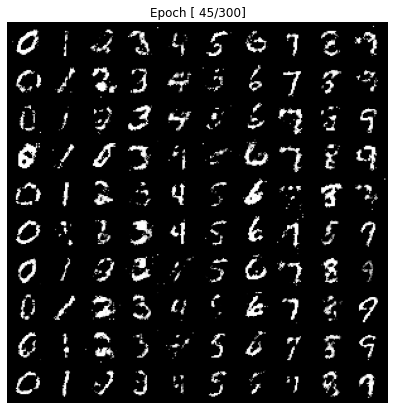

Epoch [ 46|300]    Loss [D:1.258229 | G:0.824743]    [D(x)  0.550984| D(G(z)) 0.463582]
Epoch [ 47|300]    Loss [D:1.306929 | G:0.815700]    [D(x)  0.528145| D(G(z)) 0.463342]
Epoch [ 48|300]    Loss [D:1.422599 | G:0.696193]    [D(x)  0.538225| D(G(z)) 0.523256]
Epoch [ 49|300]    Loss [D:1.366284 | G:0.788475]    [D(x)  0.532442| D(G(z)) 0.481659]
Epoch [ 50|300]    Loss [D:1.408863 | G:0.789279]    [D(x)  0.534159| D(G(z)) 0.518680]
Epoch [ 51|300]    Loss [D:1.323016 | G:0.724500]    [D(x)  0.541306| D(G(z)) 0.484315]
Epoch [ 52|300]    Loss [D:1.370269 | G:0.752689]    [D(x)  0.540141| D(G(z)) 0.502388]
Epoch [ 53|300]    Loss [D:1.386385 | G:0.790408]    [D(x)  0.524767| D(G(z)) 0.490461]
Epoch [ 54|300]    Loss [D:1.490470 | G:0.715166]    [D(x)  0.479146| D(G(z)) 0.508020]
Epoch [ 55|300]    Loss [D:1.321689 | G:0.721078]    [D(x)  0.548180| D(G(z)) 0.494935]
Epoch [ 56|300]    Loss [D:1.303155 | G:0.815825]    [D(x)  0.536702| D(G(z)) 0.473048]
Epoch [ 57|300]    Loss [D:1.428

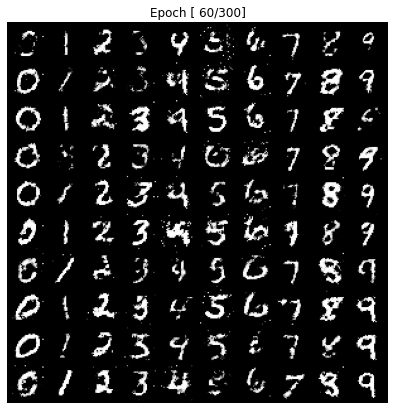

Epoch [ 61|300]    Loss [D:1.358638 | G:0.723698]    [D(x)  0.513775| D(G(z)) 0.481618]
Epoch [ 62|300]    Loss [D:1.236569 | G:0.834705]    [D(x)  0.565900| D(G(z)) 0.469276]
Epoch [ 63|300]    Loss [D:1.382485 | G:0.748118]    [D(x)  0.498296| D(G(z)) 0.483281]
Epoch [ 64|300]    Loss [D:1.445792 | G:0.741945]    [D(x)  0.489249| D(G(z)) 0.495276]
Epoch [ 65|300]    Loss [D:1.253469 | G:0.808390]    [D(x)  0.530500| D(G(z)) 0.447308]
Epoch [ 66|300]    Loss [D:1.333181 | G:0.801962]    [D(x)  0.511618| D(G(z)) 0.464720]
Epoch [ 67|300]    Loss [D:1.319023 | G:0.855509]    [D(x)  0.504392| D(G(z)) 0.445906]
Epoch [ 68|300]    Loss [D:1.407537 | G:0.774258]    [D(x)  0.488619| D(G(z)) 0.472556]
Epoch [ 69|300]    Loss [D:1.317788 | G:0.738616]    [D(x)  0.539544| D(G(z)) 0.485601]
Epoch [ 70|300]    Loss [D:1.395597 | G:0.747000]    [D(x)  0.509645| D(G(z)) 0.487670]
Epoch [ 71|300]    Loss [D:1.418951 | G:0.721311]    [D(x)  0.500401| D(G(z)) 0.500957]
Epoch [ 72|300]    Loss [D:1.316

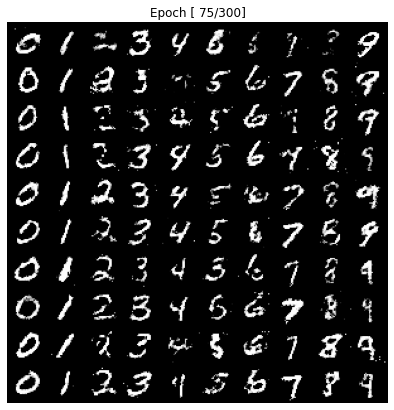

Epoch [ 76|300]    Loss [D:1.321125 | G:0.753937]    [D(x)  0.519997| D(G(z)) 0.465056]
Epoch [ 77|300]    Loss [D:1.360223 | G:0.778127]    [D(x)  0.510083| D(G(z)) 0.482172]
Epoch [ 78|300]    Loss [D:1.361211 | G:0.762326]    [D(x)  0.508235| D(G(z)) 0.478561]
Epoch [ 79|300]    Loss [D:1.382889 | G:0.771406]    [D(x)  0.503839| D(G(z)) 0.480399]
Epoch [ 80|300]    Loss [D:1.322095 | G:0.800513]    [D(x)  0.517299| D(G(z)) 0.466283]
Epoch [ 81|300]    Loss [D:1.356665 | G:0.782753]    [D(x)  0.519487| D(G(z)) 0.484306]
Epoch [ 82|300]    Loss [D:1.334960 | G:0.788610]    [D(x)  0.513564| D(G(z)) 0.471281]
Epoch [ 83|300]    Loss [D:1.369779 | G:0.760902]    [D(x)  0.497247| D(G(z)) 0.475162]
Epoch [ 84|300]    Loss [D:1.388556 | G:0.807992]    [D(x)  0.482381| D(G(z)) 0.468074]
Epoch [ 85|300]    Loss [D:1.378444 | G:0.701401]    [D(x)  0.513119| D(G(z)) 0.490098]
Epoch [ 86|300]    Loss [D:1.307045 | G:0.792061]    [D(x)  0.531891| D(G(z)) 0.473053]
Epoch [ 87|300]    Loss [D:1.376

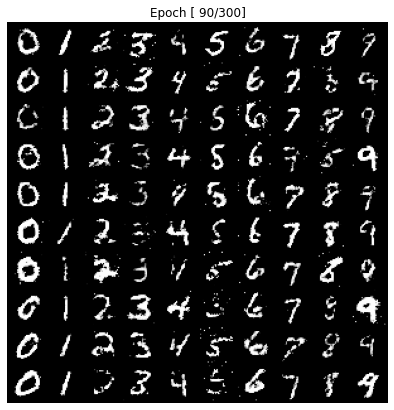

Epoch [ 91|300]    Loss [D:1.427709 | G:0.768989]    [D(x)  0.499071| D(G(z)) 0.501021]
Epoch [ 92|300]    Loss [D:1.359591 | G:0.727935]    [D(x)  0.527206| D(G(z)) 0.493586]
Epoch [ 93|300]    Loss [D:1.429163 | G:0.726282]    [D(x)  0.508563| D(G(z)) 0.512908]
Epoch [ 94|300]    Loss [D:1.336958 | G:0.785693]    [D(x)  0.511947| D(G(z)) 0.473327]
Epoch [ 95|300]    Loss [D:1.324217 | G:0.704443]    [D(x)  0.535396| D(G(z)) 0.488968]
Epoch [ 96|300]    Loss [D:1.375903 | G:0.749659]    [D(x)  0.508096| D(G(z)) 0.483138]
Epoch [ 97|300]    Loss [D:1.391029 | G:0.759251]    [D(x)  0.511819| D(G(z)) 0.492939]
Epoch [ 98|300]    Loss [D:1.378152 | G:0.777584]    [D(x)  0.496989| D(G(z)) 0.477534]
Epoch [ 99|300]    Loss [D:1.425156 | G:0.688326]    [D(x)  0.502195| D(G(z)) 0.503671]
Epoch [100|300]    Loss [D:1.337559 | G:0.750219]    [D(x)  0.520893| D(G(z)) 0.484471]
Epoch [101|300]    Loss [D:1.399263 | G:0.695585]    [D(x)  0.498515| D(G(z)) 0.492169]
Epoch [102|300]    Loss [D:1.396

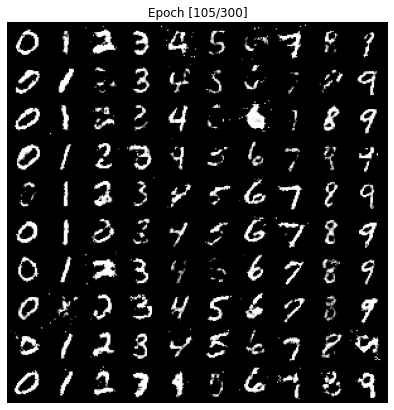

Epoch [106|300]    Loss [D:1.384633 | G:0.680684]    [D(x)  0.521727| D(G(z)) 0.511166]
Epoch [107|300]    Loss [D:1.360615 | G:0.715577]    [D(x)  0.529675| D(G(z)) 0.501450]
Epoch [108|300]    Loss [D:1.328319 | G:0.730304]    [D(x)  0.523692| D(G(z)) 0.474890]
Epoch [109|300]    Loss [D:1.339482 | G:0.780753]    [D(x)  0.509082| D(G(z)) 0.475727]
Epoch [110|300]    Loss [D:1.327349 | G:0.843222]    [D(x)  0.491304| D(G(z)) 0.445759]
Epoch [111|300]    Loss [D:1.391697 | G:0.691903]    [D(x)  0.511273| D(G(z)) 0.501019]
Epoch [112|300]    Loss [D:1.399181 | G:0.719591]    [D(x)  0.512093| D(G(z)) 0.505275]
Epoch [113|300]    Loss [D:1.344120 | G:0.775640]    [D(x)  0.509563| D(G(z)) 0.475145]
Epoch [114|300]    Loss [D:1.363697 | G:0.771122]    [D(x)  0.500099| D(G(z)) 0.475174]
Epoch [115|300]    Loss [D:1.355642 | G:0.744002]    [D(x)  0.523601| D(G(z)) 0.492504]
Epoch [116|300]    Loss [D:1.408509 | G:0.724018]    [D(x)  0.512993| D(G(z)) 0.504933]
Epoch [117|300]    Loss [D:1.381

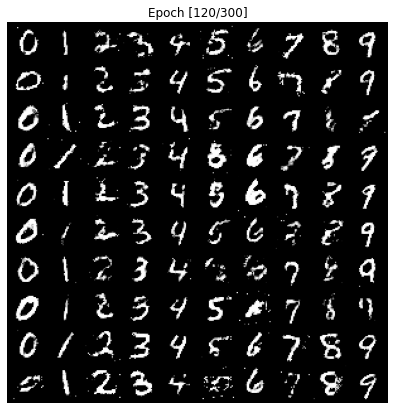

Epoch [121|300]    Loss [D:1.376243 | G:0.723120]    [D(x)  0.494708| D(G(z)) 0.474949]
Epoch [122|300]    Loss [D:1.408268 | G:0.714455]    [D(x)  0.501902| D(G(z)) 0.499842]
Epoch [123|300]    Loss [D:1.348711 | G:0.733415]    [D(x)  0.527142| D(G(z)) 0.493668]
Epoch [124|300]    Loss [D:1.327128 | G:0.787622]    [D(x)  0.530559| D(G(z)) 0.484490]
Epoch [125|300]    Loss [D:1.335241 | G:0.781581]    [D(x)  0.508040| D(G(z)) 0.464505]
Epoch [126|300]    Loss [D:1.352646 | G:0.736390]    [D(x)  0.515470| D(G(z)) 0.485229]
Epoch [127|300]    Loss [D:1.365159 | G:0.766023]    [D(x)  0.511534| D(G(z)) 0.489824]
Epoch [128|300]    Loss [D:1.376786 | G:0.706482]    [D(x)  0.523030| D(G(z)) 0.499180]
Epoch [129|300]    Loss [D:1.372310 | G:0.751989]    [D(x)  0.519671| D(G(z)) 0.492869]
Epoch [130|300]    Loss [D:1.399741 | G:0.724701]    [D(x)  0.531771| D(G(z)) 0.519778]
Epoch [131|300]    Loss [D:1.334119 | G:0.699665]    [D(x)  0.547889| D(G(z)) 0.504950]
Epoch [132|300]    Loss [D:1.376

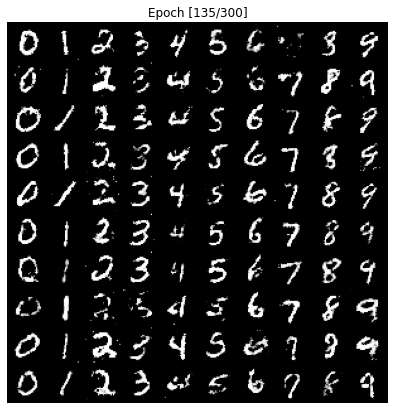

Epoch [136|300]    Loss [D:1.399499 | G:0.736582]    [D(x)  0.508384| D(G(z)) 0.504011]
Epoch [137|300]    Loss [D:1.335756 | G:0.763956]    [D(x)  0.523751| D(G(z)) 0.485868]
Epoch [138|300]    Loss [D:1.356270 | G:0.804942]    [D(x)  0.508499| D(G(z)) 0.482141]
Epoch [139|300]    Loss [D:1.335559 | G:0.743286]    [D(x)  0.525941| D(G(z)) 0.490717]
Epoch [140|300]    Loss [D:1.309367 | G:0.758359]    [D(x)  0.524239| D(G(z)) 0.473793]
Epoch [141|300]    Loss [D:1.371645 | G:0.797645]    [D(x)  0.503345| D(G(z)) 0.476154]
Epoch [142|300]    Loss [D:1.416350 | G:0.717349]    [D(x)  0.508216| D(G(z)) 0.505196]
Epoch [143|300]    Loss [D:1.397253 | G:0.695583]    [D(x)  0.507462| D(G(z)) 0.501161]
Epoch [144|300]    Loss [D:1.363365 | G:0.685270]    [D(x)  0.522604| D(G(z)) 0.501293]
Epoch [145|300]    Loss [D:1.393616 | G:0.709000]    [D(x)  0.502245| D(G(z)) 0.491670]
Epoch [146|300]    Loss [D:1.395684 | G:0.717210]    [D(x)  0.517495| D(G(z)) 0.506298]
Epoch [147|300]    Loss [D:1.367

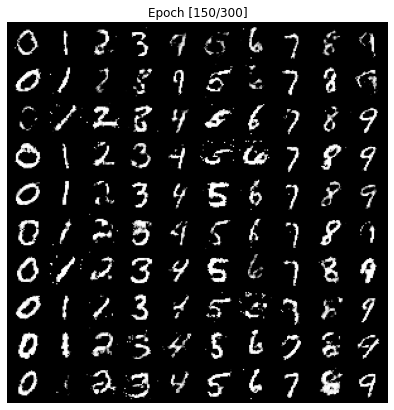

Epoch [151|300]    Loss [D:1.401444 | G:0.703817]    [D(x)  0.511494| D(G(z)) 0.507567]
Epoch [152|300]    Loss [D:1.335382 | G:0.727512]    [D(x)  0.522511| D(G(z)) 0.487045]
Epoch [153|300]    Loss [D:1.378916 | G:0.713007]    [D(x)  0.519685| D(G(z)) 0.499366]
Epoch [154|300]    Loss [D:1.404172 | G:0.759946]    [D(x)  0.511336| D(G(z)) 0.503501]
Epoch [155|300]    Loss [D:1.386771 | G:0.738966]    [D(x)  0.493368| D(G(z)) 0.477789]
Epoch [156|300]    Loss [D:1.363815 | G:0.787390]    [D(x)  0.491370| D(G(z)) 0.466627]
Epoch [157|300]    Loss [D:1.374935 | G:0.746856]    [D(x)  0.499157| D(G(z)) 0.478991]
Epoch [158|300]    Loss [D:1.387831 | G:0.740107]    [D(x)  0.490377| D(G(z)) 0.478498]
Epoch [159|300]    Loss [D:1.358961 | G:0.743395]    [D(x)  0.512966| D(G(z)) 0.484579]
Epoch [160|300]    Loss [D:1.337063 | G:0.728954]    [D(x)  0.513824| D(G(z)) 0.482996]
Epoch [161|300]    Loss [D:1.399076 | G:0.694055]    [D(x)  0.482073| D(G(z)) 0.478938]
Epoch [162|300]    Loss [D:1.439

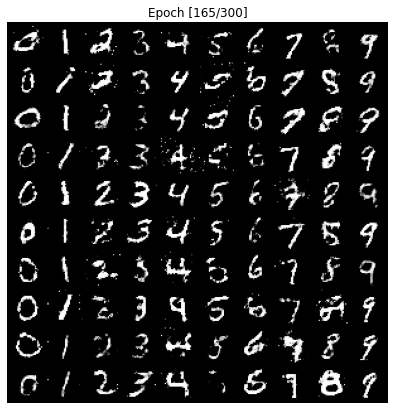

Epoch [166|300]    Loss [D:1.389903 | G:0.726922]    [D(x)  0.497570| D(G(z)) 0.489467]
Epoch [167|300]    Loss [D:1.399793 | G:0.763675]    [D(x)  0.480403| D(G(z)) 0.471389]
Epoch [168|300]    Loss [D:1.377642 | G:0.681442]    [D(x)  0.519502| D(G(z)) 0.504398]
Epoch [169|300]    Loss [D:1.358143 | G:0.777424]    [D(x)  0.505286| D(G(z)) 0.474960]
Epoch [170|300]    Loss [D:1.322791 | G:0.755437]    [D(x)  0.530517| D(G(z)) 0.487761]
Epoch [171|300]    Loss [D:1.366088 | G:0.774678]    [D(x)  0.497142| D(G(z)) 0.471944]
Epoch [172|300]    Loss [D:1.411896 | G:0.701879]    [D(x)  0.501304| D(G(z)) 0.495130]
Epoch [173|300]    Loss [D:1.377317 | G:0.699112]    [D(x)  0.516830| D(G(z)) 0.502682]
Epoch [174|300]    Loss [D:1.370203 | G:0.717123]    [D(x)  0.525429| D(G(z)) 0.507218]
Epoch [175|300]    Loss [D:1.343365 | G:0.674318]    [D(x)  0.525848| D(G(z)) 0.491817]
Epoch [176|300]    Loss [D:1.388540 | G:0.797081]    [D(x)  0.485323| D(G(z)) 0.471765]
Epoch [177|300]    Loss [D:1.327

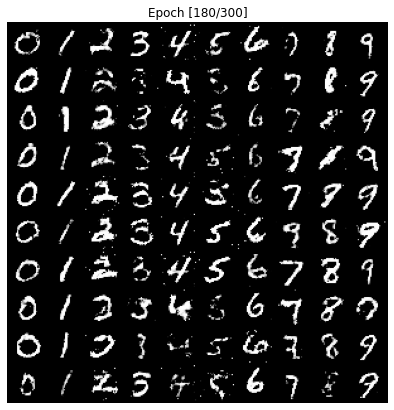

Epoch [181|300]    Loss [D:1.371109 | G:0.798851]    [D(x)  0.506897| D(G(z)) 0.484408]
Epoch [182|300]    Loss [D:1.363221 | G:0.716967]    [D(x)  0.523968| D(G(z)) 0.499221]
Epoch [183|300]    Loss [D:1.376203 | G:0.750123]    [D(x)  0.499585| D(G(z)) 0.483548]
Epoch [184|300]    Loss [D:1.379514 | G:0.729643]    [D(x)  0.502731| D(G(z)) 0.489149]
Epoch [185|300]    Loss [D:1.383182 | G:0.690679]    [D(x)  0.523447| D(G(z)) 0.508911]
Epoch [186|300]    Loss [D:1.379753 | G:0.697986]    [D(x)  0.504120| D(G(z)) 0.490830]
Epoch [187|300]    Loss [D:1.372887 | G:0.727509]    [D(x)  0.502349| D(G(z)) 0.484185]
Epoch [188|300]    Loss [D:1.429435 | G:0.734644]    [D(x)  0.498742| D(G(z)) 0.507910]
Epoch [189|300]    Loss [D:1.341284 | G:0.732404]    [D(x)  0.526676| D(G(z)) 0.493996]
Epoch [190|300]    Loss [D:1.356455 | G:0.700349]    [D(x)  0.517397| D(G(z)) 0.493976]
Epoch [191|300]    Loss [D:1.406489 | G:0.707163]    [D(x)  0.505580| D(G(z)) 0.505666]
Epoch [192|300]    Loss [D:1.385

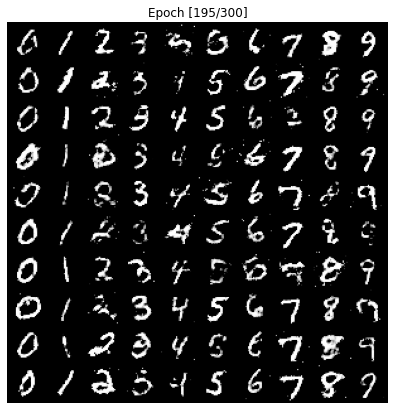

Epoch [196|300]    Loss [D:1.375251 | G:0.682887]    [D(x)  0.526045| D(G(z)) 0.509796]
Epoch [197|300]    Loss [D:1.389593 | G:0.712513]    [D(x)  0.508191| D(G(z)) 0.500790]
Epoch [198|300]    Loss [D:1.370431 | G:0.667422]    [D(x)  0.533028| D(G(z)) 0.516711]
Epoch [199|300]    Loss [D:1.374661 | G:0.715703]    [D(x)  0.511097| D(G(z)) 0.496318]
Epoch [200|300]    Loss [D:1.384575 | G:0.721753]    [D(x)  0.488480| D(G(z)) 0.478998]
Epoch [201|300]    Loss [D:1.410472 | G:0.722380]    [D(x)  0.507736| D(G(z)) 0.508185]
Epoch [202|300]    Loss [D:1.355731 | G:0.741106]    [D(x)  0.519146| D(G(z)) 0.491668]
Epoch [203|300]    Loss [D:1.387906 | G:0.784964]    [D(x)  0.495292| D(G(z)) 0.480919]
Epoch [204|300]    Loss [D:1.365919 | G:0.721103]    [D(x)  0.513898| D(G(z)) 0.496731]
Epoch [205|300]    Loss [D:1.364963 | G:0.741040]    [D(x)  0.500355| D(G(z)) 0.479008]
Epoch [206|300]    Loss [D:1.407037 | G:0.713088]    [D(x)  0.517150| D(G(z)) 0.513632]
Epoch [207|300]    Loss [D:1.414

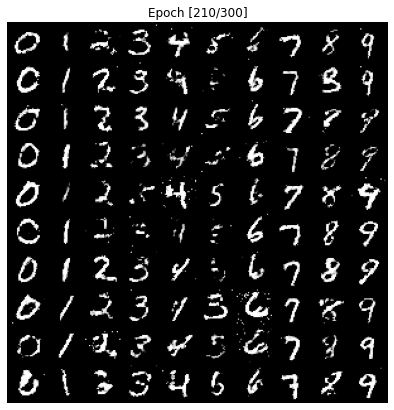

Epoch [211|300]    Loss [D:1.373274 | G:0.799556]    [D(x)  0.487308| D(G(z)) 0.471681]
Epoch [212|300]    Loss [D:1.391602 | G:0.712821]    [D(x)  0.531920| D(G(z)) 0.522062]
Epoch [213|300]    Loss [D:1.392721 | G:0.680015]    [D(x)  0.523347| D(G(z)) 0.515241]
Epoch [214|300]    Loss [D:1.365866 | G:0.682039]    [D(x)  0.518433| D(G(z)) 0.497713]
Epoch [215|300]    Loss [D:1.363854 | G:0.716812]    [D(x)  0.515976| D(G(z)) 0.494200]
Epoch [216|300]    Loss [D:1.342573 | G:0.684001]    [D(x)  0.545521| D(G(z)) 0.512756]
Epoch [217|300]    Loss [D:1.367131 | G:0.722739]    [D(x)  0.516129| D(G(z)) 0.500040]
Epoch [218|300]    Loss [D:1.410886 | G:0.699386]    [D(x)  0.508932| D(G(z)) 0.508896]
Epoch [219|300]    Loss [D:1.378644 | G:0.733547]    [D(x)  0.499600| D(G(z)) 0.477425]
Epoch [220|300]    Loss [D:1.340959 | G:0.782809]    [D(x)  0.500012| D(G(z)) 0.465242]
Epoch [221|300]    Loss [D:1.365360 | G:0.688743]    [D(x)  0.527828| D(G(z)) 0.507213]
Epoch [222|300]    Loss [D:1.330

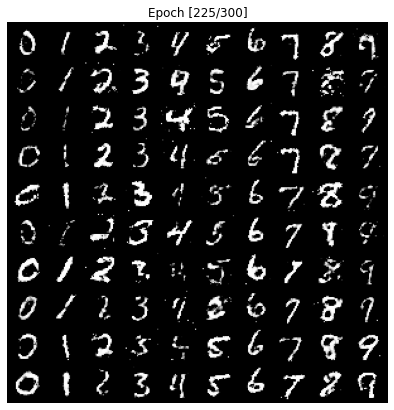

Epoch [226|300]    Loss [D:1.423578 | G:0.727747]    [D(x)  0.494798| D(G(z)) 0.503556]
Epoch [227|300]    Loss [D:1.363058 | G:0.708826]    [D(x)  0.513930| D(G(z)) 0.490453]
Epoch [228|300]    Loss [D:1.411403 | G:0.766101]    [D(x)  0.488109| D(G(z)) 0.485178]
Epoch [229|300]    Loss [D:1.366017 | G:0.692812]    [D(x)  0.519287| D(G(z)) 0.501663]
Epoch [230|300]    Loss [D:1.354871 | G:0.739066]    [D(x)  0.531452| D(G(z)) 0.505656]
Epoch [231|300]    Loss [D:1.420054 | G:0.714281]    [D(x)  0.504525| D(G(z)) 0.510396]
Epoch [232|300]    Loss [D:1.360977 | G:0.722513]    [D(x)  0.512629| D(G(z)) 0.489771]
Epoch [233|300]    Loss [D:1.382833 | G:0.718871]    [D(x)  0.507328| D(G(z)) 0.492786]
Epoch [234|300]    Loss [D:1.376534 | G:0.714906]    [D(x)  0.507583| D(G(z)) 0.491146]
Epoch [235|300]    Loss [D:1.393884 | G:0.689312]    [D(x)  0.520118| D(G(z)) 0.509923]
Epoch [236|300]    Loss [D:1.395837 | G:0.637857]    [D(x)  0.538127| D(G(z)) 0.529058]
Epoch [237|300]    Loss [D:1.348

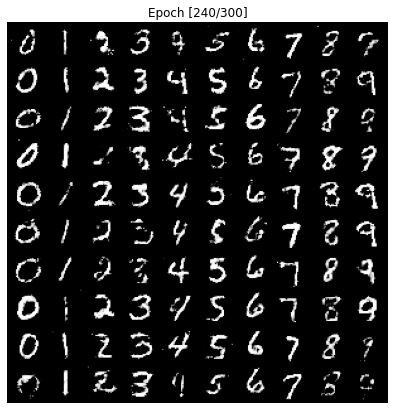

Epoch [241|300]    Loss [D:1.392689 | G:0.687271]    [D(x)  0.519061| D(G(z)) 0.513992]
Epoch [242|300]    Loss [D:1.399039 | G:0.692147]    [D(x)  0.512521| D(G(z)) 0.508336]
Epoch [243|300]    Loss [D:1.386495 | G:0.690948]    [D(x)  0.528593| D(G(z)) 0.512075]
Epoch [244|300]    Loss [D:1.351679 | G:0.757611]    [D(x)  0.511593| D(G(z)) 0.481032]
Epoch [245|300]    Loss [D:1.343171 | G:0.716657]    [D(x)  0.529832| D(G(z)) 0.495729]
Epoch [246|300]    Loss [D:1.400378 | G:0.724739]    [D(x)  0.488088| D(G(z)) 0.485275]
Epoch [247|300]    Loss [D:1.316738 | G:0.760080]    [D(x)  0.506839| D(G(z)) 0.460701]
Epoch [248|300]    Loss [D:1.355003 | G:0.704075]    [D(x)  0.505735| D(G(z)) 0.483778]
Epoch [249|300]    Loss [D:1.358446 | G:0.732947]    [D(x)  0.496250| D(G(z)) 0.471799]
Epoch [250|300]    Loss [D:1.394197 | G:0.771336]    [D(x)  0.505227| D(G(z)) 0.494801]
Epoch [251|300]    Loss [D:1.409873 | G:0.689701]    [D(x)  0.514618| D(G(z)) 0.517284]
Epoch [252|300]    Loss [D:1.383

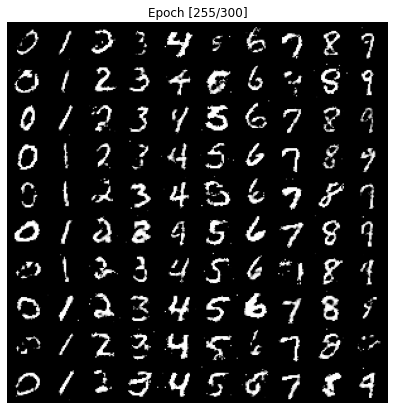

Epoch [256|300]    Loss [D:1.410269 | G:0.733234]    [D(x)  0.481624| D(G(z)) 0.483913]
Epoch [257|300]    Loss [D:1.356586 | G:0.742937]    [D(x)  0.502904| D(G(z)) 0.475530]
Epoch [258|300]    Loss [D:1.342205 | G:0.767535]    [D(x)  0.502335| D(G(z)) 0.472183]
Epoch [259|300]    Loss [D:1.395791 | G:0.777553]    [D(x)  0.476035| D(G(z)) 0.470025]
Epoch [260|300]    Loss [D:1.355657 | G:0.779699]    [D(x)  0.503517| D(G(z)) 0.477331]
Epoch [261|300]    Loss [D:1.371130 | G:0.731325]    [D(x)  0.504496| D(G(z)) 0.487059]
Epoch [262|300]    Loss [D:1.352997 | G:0.771190]    [D(x)  0.500649| D(G(z)) 0.476204]
Epoch [263|300]    Loss [D:1.394585 | G:0.703684]    [D(x)  0.495034| D(G(z)) 0.489776]
Epoch [264|300]    Loss [D:1.366700 | G:0.707035]    [D(x)  0.512885| D(G(z)) 0.492728]
Epoch [265|300]    Loss [D:1.366784 | G:0.701473]    [D(x)  0.512537| D(G(z)) 0.493719]
Epoch [266|300]    Loss [D:1.405319 | G:0.720314]    [D(x)  0.515128| D(G(z)) 0.515370]
Epoch [267|300]    Loss [D:1.378

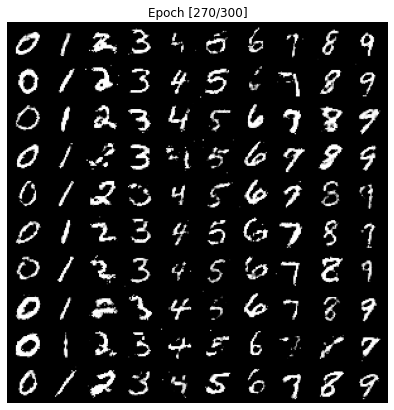

Epoch [271|300]    Loss [D:1.414649 | G:0.714857]    [D(x)  0.507054| D(G(z)) 0.510796]
Epoch [272|300]    Loss [D:1.343071 | G:0.771772]    [D(x)  0.502758| D(G(z)) 0.472281]
Epoch [273|300]    Loss [D:1.369198 | G:0.739978]    [D(x)  0.513193| D(G(z)) 0.492727]
Epoch [274|300]    Loss [D:1.459403 | G:0.653988]    [D(x)  0.524294| D(G(z)) 0.546989]
Epoch [275|300]    Loss [D:1.398305 | G:0.702390]    [D(x)  0.520488| D(G(z)) 0.513427]
Epoch [276|300]    Loss [D:1.391403 | G:0.687985]    [D(x)  0.517463| D(G(z)) 0.508451]
Epoch [277|300]    Loss [D:1.362926 | G:0.683535]    [D(x)  0.521657| D(G(z)) 0.500772]
Epoch [278|300]    Loss [D:1.398142 | G:0.697812]    [D(x)  0.502948| D(G(z)) 0.496939]
Epoch [279|300]    Loss [D:1.357847 | G:0.733704]    [D(x)  0.517798| D(G(z)) 0.492516]
Epoch [280|300]    Loss [D:1.386399 | G:0.713448]    [D(x)  0.507418| D(G(z)) 0.501094]
Epoch [281|300]    Loss [D:1.414792 | G:0.752591]    [D(x)  0.483997| D(G(z)) 0.482314]
Epoch [282|300]    Loss [D:1.431

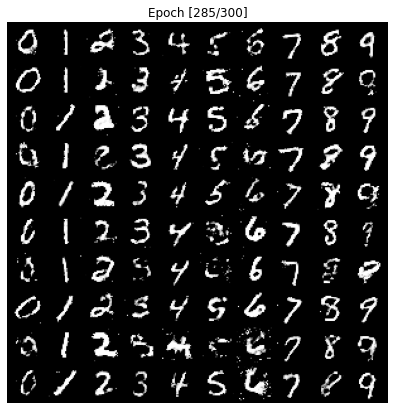

Epoch [286|300]    Loss [D:1.405391 | G:0.728097]    [D(x)  0.494641| D(G(z)) 0.492158]
Epoch [287|300]    Loss [D:1.384269 | G:0.708265]    [D(x)  0.518893| D(G(z)) 0.503029]
Epoch [288|300]    Loss [D:1.364250 | G:0.756176]    [D(x)  0.492520| D(G(z)) 0.472670]
Epoch [289|300]    Loss [D:1.401230 | G:0.730576]    [D(x)  0.490310| D(G(z)) 0.484945]
Epoch [290|300]    Loss [D:1.408715 | G:0.695688]    [D(x)  0.492627| D(G(z)) 0.492366]
Epoch [291|300]    Loss [D:1.373883 | G:0.798606]    [D(x)  0.489171| D(G(z)) 0.469302]
Epoch [292|300]    Loss [D:1.378135 | G:0.772721]    [D(x)  0.500266| D(G(z)) 0.484726]
Epoch [293|300]    Loss [D:1.419253 | G:0.714312]    [D(x)  0.486674| D(G(z)) 0.492874]
Epoch [294|300]    Loss [D:1.373994 | G:0.660868]    [D(x)  0.527270| D(G(z)) 0.511351]
Epoch [295|300]    Loss [D:1.387583 | G:0.728089]    [D(x)  0.476450| D(G(z)) 0.467064]
Epoch [296|300]    Loss [D:1.404985 | G:0.765212]    [D(x)  0.479661| D(G(z)) 0.480265]
Epoch [297|300]    Loss [D:1.403

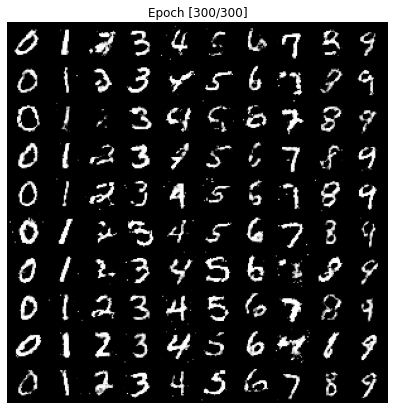

In [10]:
total_step = len(data_loader)

plt.ion()

for epoch in range(EPOCHS+1):
    for i, (images, labels) in enumerate(data_loader): #100개씩 600번
        images = images.reshape(BATCH_SIZE, -1).to(device) # 100, 1. 28, 28 크기를 100 784로 바꿔줌
        
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        
        # discriminator 먼저 학습
        labels = labels.to(device) # 100
        outputs = D(images, labels) # (100, 784)  (100)
        d_loss_real = criterion(outputs, real_labels) # BCELoss real image와 real labels로 1이 나오게 loss구함
        real_score = outputs
        
        z = torch.randn(BATCH_SIZE, 100).to(device) # 100 100 gausian noise
        g_label = torch.randint(0, 10, (BATCH_SIZE, )).to(device) #0 ~ 10 100 
        fake_image = G(z, g_label) # ganerate fake image 
        
        outputs = D(fake_image, g_label) #fake discriminate random num, 그걸로 만든 fake image
        d_loss_fake = criterion(outputs, fake_labels)#fake loss
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake #loss 합
        
        d_optim.zero_grad()
        d_loss.backward()
        d_optim.step() #학습
        
        # generator 학습
        fake_images = G(z, g_label)
        #fake_images = fake_image.detach()
        otuptus = D(fake_images, g_label)
        g_loss = criterion(otuptus, real_labels)
        
        g_optim.zero_grad()
        g_loss.backward()
        g_optim.step()  
        
    print("Epoch [{:3d}|{:3d}]    Loss [D:{:8.6f} | G:{:8.6f}]    [D(x)  {:8.6f}| D(G(z)) {:8.6f}]".format(
        epoch, EPOCHS, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()
    ))
    
    #15에폭마다 1~ 10 10개 그리기
    if epoch % 15 == 0:
        z = torch.randn(100, 100).to(device)
        sample_imgs = G(z, plot_label)
        sample_imgs = sample_imgs.reshape((100, 1, 28, 28))
        sample_imgs = torchvision.utils.make_grid(sample_imgs, nrow=10)
        plot_imgs   = np.clip(sample_imgs.data.cpu().numpy().transpose(1, 2, 0), 0, 1)

        plt.figure(figsize=(7, 7))
        plt.imshow(plot_imgs)
        plt.title("Epoch [{:3d}/{:3d}]".format(epoch, EPOCHS))
        plt.axis('off')
        plt.pause(0.001)
        
        torchvision.utils.save_image(sample_imgs, "./results/Epoch_{:3d}.png".format(epoch))
plt.ioff()

In [ ]:
detach